# GP doctors per LAD

> Imputes missing data of how many doctors per GP practice, then calculates how many doctors per LAD.

------

In [1]:
#|default_exp core.02c_doctors_per_LAD

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

from sklearn import linear_model

---

In [5]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

AttributeError: module 'dementia_inequalities.const' has no attribute 'raw_data_path'

------

## Load the relevant dataframes 

In [ ]:
#|export 
# Load data about intersections of GP catchment areas and LAD
df_LAD_GP_pop = pd.read_csv(const.pre_output_path+'/LAD_GP_area_intersections.csv')

# Loads data of GP counts 
df_GP_count = pd.read_csv(const.data_path+'/GP_practices_dec_23/gp_Count.csv')

In [ ]:
df_GP_count.head()

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,BARTS HEALTH NHS TRUST,R1H00,BARTS HEALTH NHS TRUST CHS,"BEAUMONT HOUSE, ROOM 31, MILE END HOSPITAL, LO...",Y05462,1,NaN,NaN,NaN
1,BEXLEY HEALTH NEIGHBOURHOOD CARE,DFJ00,GUARD YOUR HEART HUB,"C/O BELLGROVE SURGERY, 174 BELLGROVE ROAD, WEL...",Y08001,1,NaN,NaN,NaN
2,BMI HEALTHCARE,NT400,BMI BEAUMONT HOSPITAL,"OLD HALL CLOUGH, CHORLEY NEW ROAD LOSTOCK, BOL...",Y06646,1,NaN,NaN,NaN
3,BMI HEALTHCARE,NT400,BMI BISHOPSWOOD HOSPITAL,"RICKMANSWORTH ROAD, NORTHWOOD, MIDDLESEX, HA6 2JW",Y06603,1,NaN,NaN,NaN
4,BMI HEALTHCARE,NT400,BMI CHAUCER HOSPITAL,"NACKINGTON ROAD, CANTERBURY, KENT, CT4 7AR",Y04413,1,NaN,NaN,NaN


In [ ]:
#|export 
# reformat 
list_gps = df_LAD_GP_pop['gp_name'].values
list_gps_codes = [item[0:6] for item in list_gps]
df_LAD_GP_pop['GP_code'] = list_gps_codes

# merge 
df_LAD_GP_count = pd.merge(df_LAD_GP_pop, df_GP_count, left_on='GP_code', right_on='Code.1', how='left')

In [ ]:
df_LAD_GP_count.head()

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,0,7228,154.810845,51241.009004,Hartlepool,279.802173,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE,167.919513,167.919513,0.921935,A81070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1607,168.866010,55893.143290,Hartlepool,279.802173,A81622 - GLADSTONE HOUSE SURGERY,172.166251,172.166251,0.980831,A81622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7219,185.284987,61327.677980,Hartlepool,279.802173,A81060 - THE KOH PRACTICE,207.778224,207.778224,0.891744,A81060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7959,189.603022,62756.909149,Hartlepool,279.802173,A81044 - MCKENZIE HOUSE SURGERY,193.364841,193.364841,0.980545,A81044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2654,214.436151,70976.453448,Hartlepool,279.802173,A81007 - BANKHOUSE SURGERY,226.560820,226.560820,0.946484,A81007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#|export 
df_LAD_GP_count['GP_contribution_to_LAD'] = df_LAD_GP_count['percent_GP_in_LAD']*df_LAD_GP_count['GP Count']

# tidy up the dataframe a bit before saving it 
df_LAD_GP = df_LAD_GP_count[['LAD_name', 'GP_code', 'gp_name', 'intersection_size', 'intersection_pop', 'percent_GP_in_LAD', 'GP Count', 'GP_contribution_to_LAD']]

df_LAD_GP = df_LAD_GP.drop_duplicates()
df_LAD_GP.reset_index(inplace=True, drop=True)

df_LAD_GP.columns = ['LAD_name', 'GP_code', 'GP_name', 'area_intersection', 'pop_intersection', 'percent_GP_in_LAD', 'GP_count_practice', 'GP_contribution_to_LAD']

## Number of GPs in each LAD 

In [ ]:
#|export 
df_LAD_GP = df_LAD_GP.fillna(0)
df_GP_contribution = df_LAD_GP.groupby('LAD_name').sum()
df_GP_contribution.reset_index(inplace=True)
df_GP_contribution = df_GP_contribution[['LAD_name', 'GP_contribution_to_LAD']]

Only have GP counts for 50 of the 309 LADs.


In [ ]:
non_zero_gp_cont = len(df_GP_contribution[df_GP_contribution["GP_contribution_to_LAD"]>0])
print(f'Only have GP counts for {non_zero_gp_cont} of the 309 LADs.')

In [ ]:
# number of GP's with at least cut_off amount of catchment area in the LAD
LAD_names = df_LAD_GP['LAD_name'].unique()
cut_off = 0.3

for lad in LAD_names:
    df_LAD = df_LAD_GP[df_LAD_GP['LAD_name']==lad]
    num_GPs = len(df_LAD[df_LAD['percent_GP_in_LAD']>cut_off])
    print(f'{lad}:{num_GPs}')

Hartlepool:16
Middlesbrough:30
Redcar and Cleveland:25
Stockton-on-Tees:65
Darlington:17
Halton:49
Warrington:50
Blackburn with Darwen:31
Blackpool:25
Kingston upon Hull, City of:42
East Riding of Yorkshire:54
North East Lincolnshire:26
North Lincolnshire:23
York:13
Derby:37
Leicester:65
Rutland:5
Nottingham:58
Herefordshire, County of:33
Telford and Wrekin:16
Stoke-on-Trent:62
Bath and North East Somerset:30
Bristol, City of:48
North Somerset:13
South Gloucestershire:37
Plymouth:48
Torbay:14
Swindon:26
Peterborough:16
Luton:30
Southend-on-Sea:33
Thurrock:37
Medway:43
Bracknell Forest:20
West Berkshire:20
Reading:37
Slough:23
Windsor and Maidenhead:46
Wokingham:39
Milton Keynes:36
Brighton and Hove:49
Portsmouth:20
Southampton:53
Isle of Wight:15
County Durham:66
Cheshire East:32
Cheshire West and Chester:43
Shropshire:51
Cornwall:63
Isles of Scilly:0
Wiltshire:57
Bedford:23
Central Bedfordshire:35
Northumberland:46
Bournemouth, Christchurch and Poole:72
Dorset:57
Buckinghamshire:65
No

South Ribble:18
West Lancashire:24
Wyre:27
Blaby:11
Charnwood:25
Harborough:11
Hinckley and Bosworth:16
Melton:8
North West Leicestershire:15
Oadby and Wigston:6
Boston:8
East Lindsey:21
Lincoln:9
North Kesteven:18
South Holland:9
South Kesteven:16
West Lindsey:19
Breckland:19
Broadland:26
Great Yarmouth:7
King's Lynn and West Norfolk:31
North Norfolk:20
Norwich:22
South Norfolk:16
Craven:20
Hambleton:14
Harrogate:28
Richmondshire:18
Ryedale:8
Scarborough:20
Selby:22
Ashfield:21
Bassetlaw:11
Broxtowe:16
Gedling:24
Mansfield:16
Newark and Sherwood:18
Rushcliffe:20
Cherwell:18
Oxford:23
South Oxfordshire:28
Vale of White Horse:10
West Oxfordshire:16
Mendip:20
Sedgemoor:17
South Somerset:34
Cannock Chase:31
East Staffordshire:28
Lichfield:30
Newcastle-under-Lyme:41
South Staffordshire:31
Stafford:21
Staffordshire Moorlands:23
Tamworth:14
Babergh:11
Ipswich:16
Mid Suffolk:15
Elmbridge:24
Epsom and Ewell:8
Guildford:22
Mole Valley:13
Reigate and Banstead:17
Runnymede:13
Spelthorne:12
Surrey

## Save data

In [ ]:
#|export
df_LAD_GP.to_csv(const.pre_output_path+'/GP_LAD_inter_GP_count.csv', index=False)

## Look at GP distribution across practices
To be clear - the number of doctors per practice. 

In [ ]:
#|export
df_QOF_prev = pd.read_csv(const.data_path+'/QOF_2122_V2/PREVALENCE_2122_V2.csv')

# Only interested in Dementia diagnosis 
df_QOF_dem = df_QOF_prev[df_QOF_prev['GROUP_CODE']=='DEM'].copy()
# Drop columns which are not useful 
df_QOF_dem.drop(labels=['GROUP_CODE', 'PATIENT_LIST_TYPE'], axis=1, inplace=True)
df_QOF_dem.rename(columns={'REGISTER':'DEM_REGISTER'}, inplace=True)

In [ ]:
df_QOF_dem.head()

,PRACTICE_CODE,DEM_REGISTER,PRACTICE_LIST_SIZE
6,A81001,26.0,4045
27,A81002,205.0,18490
48,A81004,100.0,11104
69,A81005,92.0,8082
90,A81006,144.0,14534


In [ ]:
#|export
df_QOF_dem = pd.merge(df_QOF_dem, df_GP_count[['Code.1', 'GP Count']], left_on='PRACTICE_CODE', right_on='Code.1', how='left')
df_QOF_dem.drop(columns='Code.1', inplace=True)
with_GP_count = df_QOF_dem[df_QOF_dem['GP Count']>0]
with_no_GP_count = df_QOF_dem[~(df_QOF_dem['GP Count']>0)]

In [ ]:
pc_with_GP_data = len(with_GP_count)/len(df_QOF_dem)
print(f'percent of practices with GP number stats: {np.round(pc_with_GP_data, 2)}')

0.1777434312210201

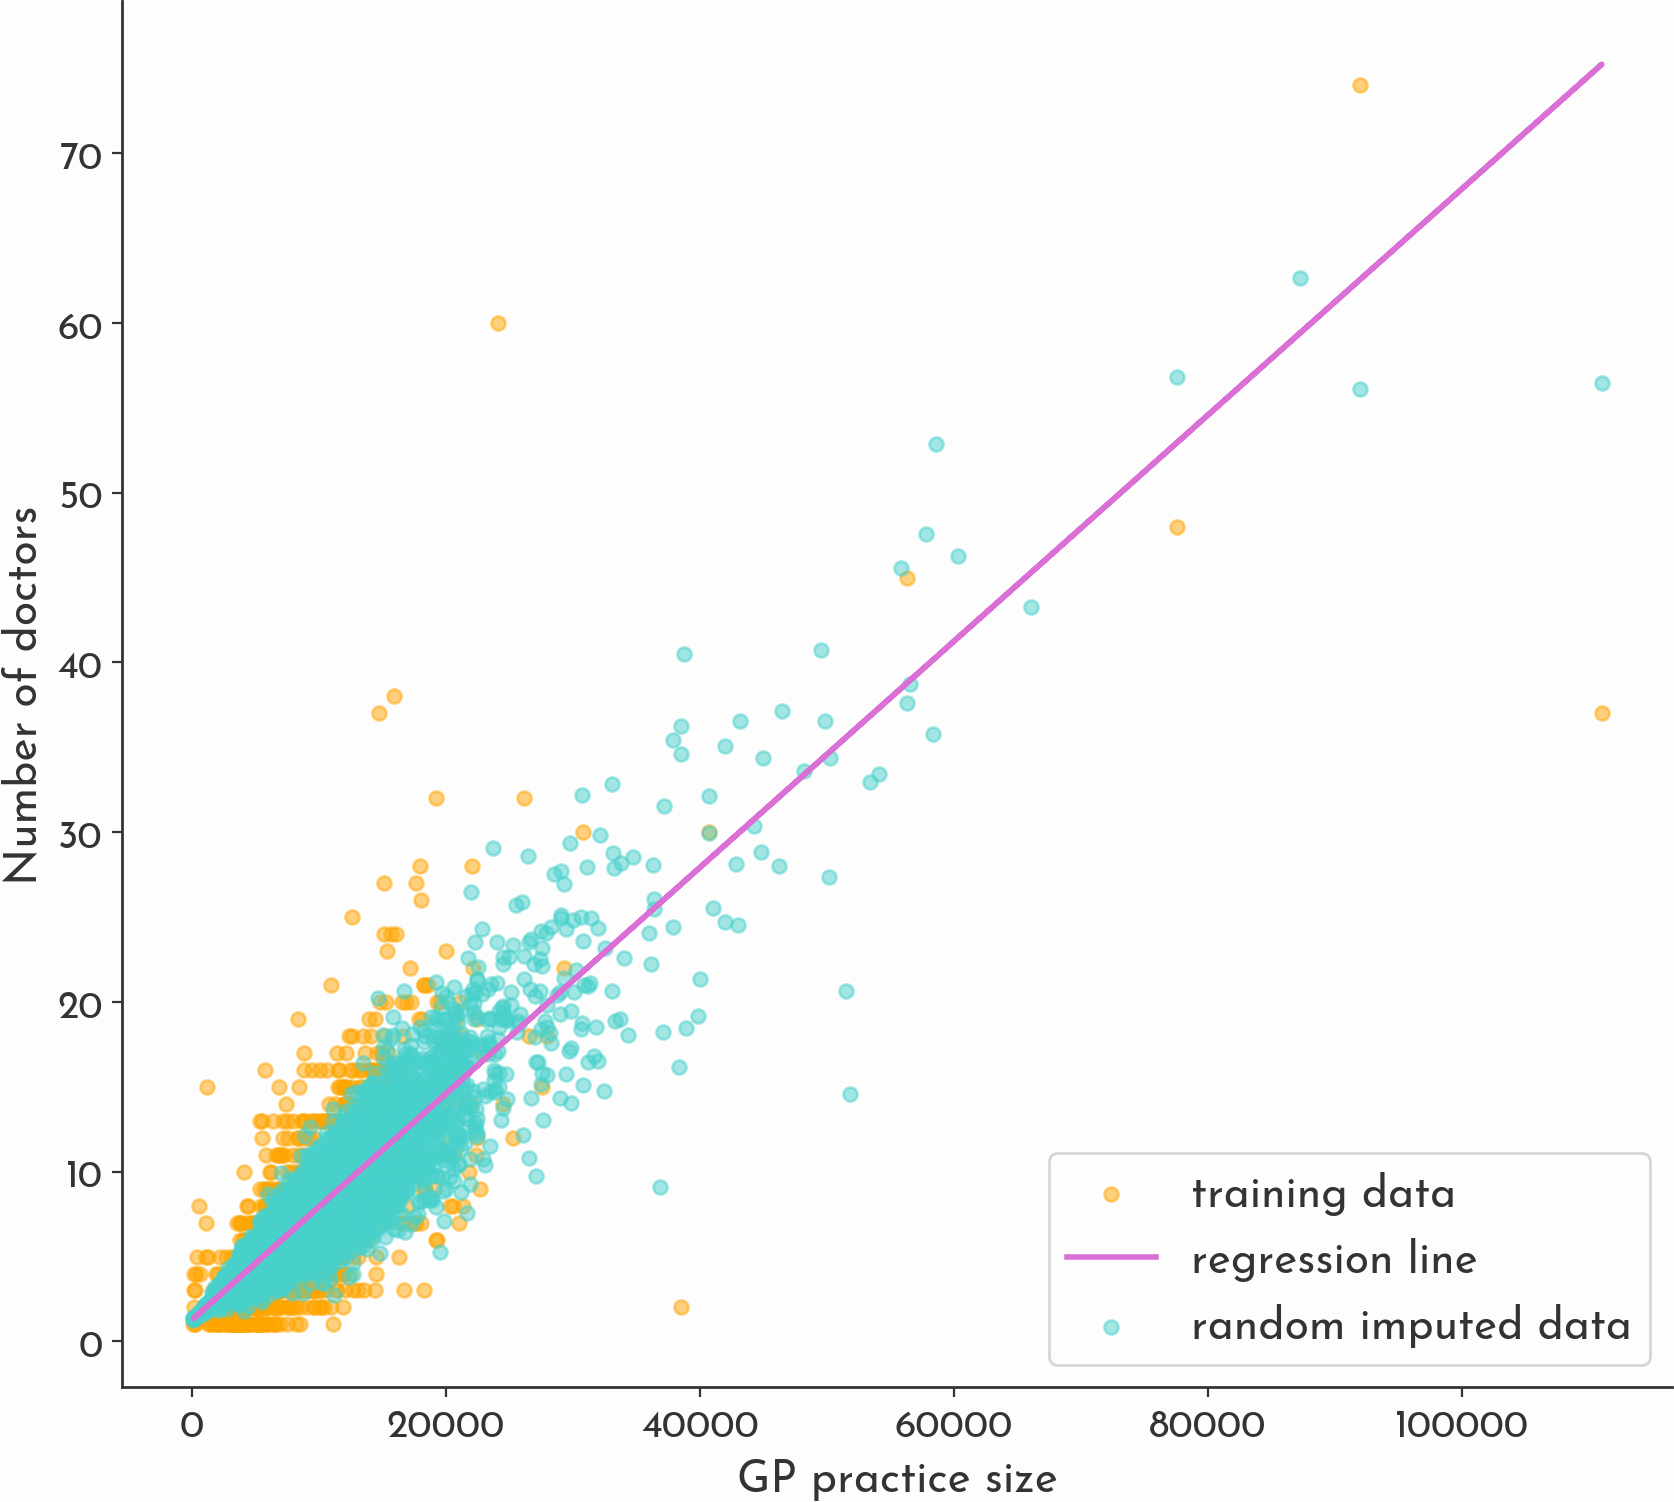

In [ ]:
#|export
# Random regression imputation with heteroskedastic error term 

# Remove datapoints where the number of doctors is over 2 deviations away from the mean
#GP_mean = np.mean(with_GP_count['GP Count'].values)
#GP_std = np.std(with_GP_count['GP Count'].values)
#GP_upper_lim = GP_mean + 3*GP_std

#with_GP_no_outliers = with_GP_count[with_GP_count['GP Count']<GP_upper_lim]

# original
x = df_QOF_dem['PRACTICE_LIST_SIZE'].values.reshape(-1,1)

# original
x_train = with_GP_count['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
y_train =  with_GP_count['GP Count'].values.reshape(-1,1)

# fit regression
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_train)

test_y_pred = regr.predict(x)

# calculate std of variance between predicted data and observed data 
resid_std = np.std(np.abs(y_train-y_pred))
# calculate hetero-skedastic noise
np.random.seed(3)
hetero_noise = 0.00005*np.abs(x) * np.random.normal(loc=0, scale=resid_std, size=x.shape)

# the imputed value - regression plus noise
y = test_y_pred + hetero_noise.reshape(-1,1)

# plot 
plt.figure(figsize=(10, 9), dpi=200)
plt.scatter(x_train, y_train, color = 'xkcd:boring green', alpha=0.5)
plt.plot(x_train, y_pred, color='xkcd:deep lilac', linewidth=2)
plt.scatter(x, y, color='xkcd:windows blue', alpha=0.5)
plt.xlabel('GP practice size', fontsize=16)
plt.ylabel('Number of doctors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['training data', 'regression line', 'random imputed data'], loc='lower right', fontsize=16)
plt.savefig(const.figs_path+'/GP_data_imputation.png')

In [ ]:
#|export
# update missing values in dataframe 
df_QOF_dem['GP_count_random_imputed_missing'] = y

df_QOF_dem['GP_count_regression_imputed'] = df_QOF_dem['GP Count']
df_QOF_dem['GP_count_regression_imputed'].fillna(df_QOF_dem['GP_count_random_imputed_missing'], inplace=True)
df_QOF_dem.drop(columns='GP_count_random_imputed_missing')

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_32822/2319437671.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_QOF_dem['GP_count_regression_imputed'].fillna(df_QOF_dem['GP_count_random_imputed_missing'], inplace=True)


,PRACTICE_CODE,DEM_REGISTER,PRACTICE_LIST_SIZE,GP Count,GP_count_regression_imputed
0,A81001,26.0,4045,NaN,5.230141
1,A81002,205.0,18490,NaN,15.660797
2,A81004,100.0,11104,NaN,9.172638
3,A81005,92.0,8082,NaN,5.384023
4,A81006,144.0,14534,NaN,7.071627
...,...,...,...,...,...
6465,Y07020,254.0,539,8.0,8.000000
6466,Y07025,70.0,9544,NaN,7.349704
6467,Y07057,63.0,11797,NaN,11.936740
6468,Y07059,118.0,19561,NaN,11.866957


Text(0, 0.5, 'Number of doctors')

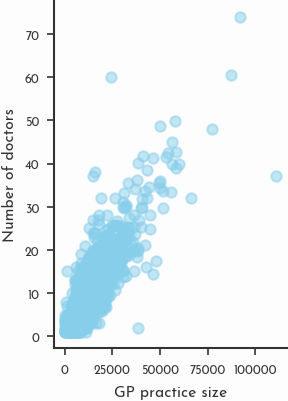

In [ ]:
# Plot all the data (original and imputed)
plt.figure(figsize=(10, 9), dpi=200)
plt.scatter(df_QOF_dem['PRACTICE_LIST_SIZE'], df_QOF_dem['GP_count_regression_imputed'], color='xkcd:boring green', alpha=0.5)
plt.xlabel('GP practice size')
plt.ylabel('Number of doctors')

## Contribution of GP doctors to each LAD 

In [ ]:
#|export
# load dataset
df_LAD_GP_count = pd.merge(df_LAD_GP_pop, df_QOF_dem[['PRACTICE_CODE', 'GP_count_regression_imputed']], left_on='GP_code', right_on='PRACTICE_CODE', how='right')
df_LAD_GP_count['GP_contribution_to_LAD'] = df_LAD_GP_count['percent_GP_in_LAD']*df_LAD_GP_count['GP_count_regression_imputed']

# tidy up the dataframe a bit before saving it 
df_LAD_GP = df_LAD_GP_count[['LAD_name', 'GP_code', 'gp_name', 'intersection_size', 'intersection_pop', 'percent_GP_in_LAD', 'GP_count_regression_imputed', 'GP_contribution_to_LAD']]
df_LAD_GP.reset_index(inplace=True, drop=True)
df_LAD_GP.columns = ['LAD_name', 'GP_code', 'GP_name', 'area_intersection', 'pop_intersection', 'percent_GP_in_LAD', 'GP_count_practice_imputed', 'GP_contribution_to_LAD']

In [ ]:
df_LAD_GP_count[df_LAD_GP_count['percent_GP_in_LAD']<0]

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code,PRACTICE_CODE,GP_count_regression_imputed,GP_contribution_to_LAD


In [ ]:
#|export
df_GP_contribution = df_LAD_GP.groupby('LAD_name').sum()
df_GP_contribution.reset_index(inplace=True)
df_GP_contribution = df_GP_contribution[['LAD_name', 'GP_contribution_to_LAD']]

Have GP counts for 309 of the 309 LADs.


In [ ]:
non_zero_gp_cont = len(df_GP_contribution[df_GP_contribution["GP_contribution_to_LAD"]>0])
print(f'Have GP counts for {non_zero_gp_cont} of the 309 LADs.')

In [ ]:
print(len(df_LAD_GP_pop[df_LAD_GP_pop['gp_area']<0]))
print(len(df_GP_contribution[df_GP_contribution['GP_contribution_to_LAD']<=0]))

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code


In [ ]:
#|export 
# save the dataframe 
df_GP_contribution.to_csv(const.pre_output_path+'/GP_contribution_LAD.csv', index=False)